In [54]:
# Setup.
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline 


def load_data(path_to_file):
    
    df = pd.read_csv(path_to_file, header=None)
    
    if df.values.dtype is not np.dtype(int):
        
        X = []
        for i, x in df.iterrows():
            X.append(eval((",").join(x.values[0].split(" "))))
            
        df = pd.DataFrame(X)
        
    return df


a = np.squeeze(load_data("data/medical/historical_A.dat").values)
y = np.squeeze(load_data("data/medical/historical_Y.dat").values)
x = load_data("data/medical/historical_X.dat").values

gender = x[:, 0]
smoker = x[:, 1]
genes = x[:, 2:127]
symp = x[:, 128:]

The following figure illustrates that action $a_1$ has led to more $y_1$ outcomes compared to action $a_0$. However, both actions $a_0$ and $a_1$ has also led to the outcome $y_0$. Moreover, we observe that the distribution of actions and outcomes is heavily skewed towards $a_1$ and $y_1$, respectively.

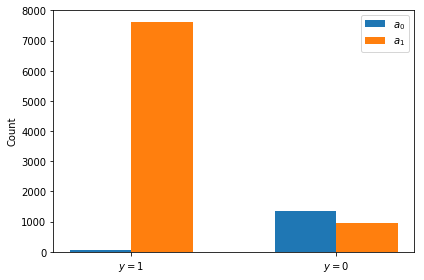

In [13]:
_, axis = plt.subplots(1, 1)

N = 2
ind = np.arange(N)
width = N / 4 - 0.2

rects1 = axis.bar(ind, [sum(y[a == 0]), sum(y[a == 1])], width)
rects2 = axis.bar(ind + width, [sum(y[a == 0] == 0), sum(y[a == 1] == 0)], width)

axis.set_ylabel('Count')
axis.set_xticks(ind + width / 2)
axis.set_xticklabels((r"$y = 1$", r"$y = 0$"))
axis.legend((rects1[0], rects2[0]), ["$a_0$", "$a_1$"])
plt.tight_layout()

## Effect of treatment

Assuming $a_0$ means placebo, $a_1$ is the active treament, $y_1$ is successfull treatment and $y_0$ is un-successfull treatment. To quantify the effectiveness of the placebo $a_0$ versus the active treatment $a_1$ we use the [relative risk score](https://adc.bmj.com/content/90/1/54.full) $RR$. The Bayesian interpretation of this score, namely

$$
RR = \frac{P(y_1 \mid a_1)}{P(y_1 \mid a_0)}
$$

gives the ratio of successfull treatments $P(y_1 \mid a_1)$ divided by the ratio of placebo responders $P(y_1 \mid a_0)$. If $RR > 1$, then $P(y_1 \mid a_1) > P(y_1 \mid a_0)$ in which case the active treatment $a_1$ lead to more successfull outcomes $y_1$ compared to placebo $a_0$.

In [14]:
def rr_score(a, y) -> float:
    """Compute the relative risk score given actions a and outcomes y."""

    p_y1_given_a0 = sum(y[a == 0] == 1) / sum(a == 0)
    p_y1_given_a1 = sum(y[a == 1] == 1) / sum(a == 1)

    return p_y1_given_a1 / p_y1_given_a0

In [15]:
# Measures the effectiveness of the treatment vs. placebo.
print("RR score male:", rr_score(a[gender == 1], y[gender == 1]))
print("RR score female:", rr_score(a[gender == 0], y[gender == 0]))
print("RR score smoker:", rr_score(a[smoker == 1], y[smoker == 1]))
print("RR score non-smoker:", rr_score(a[smoker == 0], y[smoker == 0]))

RR score male: 53.269982993197274
RR score female: 87.31344028520499
RR score smoker: 103.94162538492436
RR score non-smoker: 58.577538284594574


According to the $RR$ acore and assuming $gender = 1$ indicates male (quite common in epidemiology), treatment appears to be more effective on females and smokers than females and non-smokers. Furthermore, we can study the impact of $y_1$ on the gender sub-groups conditioned on whether or not they smoke:

In [16]:
male_idx = gender == 1
female_idx = gender == 0

print("RR smoking male:", rr_score(a[male_idx][smoker[male_idx] == 1], 
                                   y[male_idx][smoker[male_idx] == 1]))

print("RR non-smoking male:", rr_score(a[male_idx][smoker[male_idx] == 0], 
                                       y[male_idx][smoker[male_idx] == 0]))

print("RR smoking female:", rr_score(a[female_idx][smoker[female_idx] == 1], 
                                     y[female_idx][smoker[female_idx] == 1]))

print("RR non-smoking female:", rr_score(a[female_idx][smoker[female_idx] == 0], 
                                         y[female_idx][smoker[female_idx] == 0]))


RR smoking male: 86.69682835820896
RR non-smoking male: 46.00143554407121
RR smoking female: 149.89651022864018
RR non-smoking female: 78.9722969338354


According to the $RR$ scores, we observe across gender that smokers are more responsive to treatment than non-smokers. This could mean that smoking impacts/correlates to the underlying condition targeted by the treatment.

From the data we see that a placebo was given if neither symptom 1 nor 2 were present. However, 30 of these about 4800 cases resulted in a measurable effect of the placebo. 

In [93]:
s1, s2 = symp[:, 0], symp[:, 1]

sum(a[np.logical_and(s1 == 0, s2 == 0)]), sum(y[np.logical_and(s1 == 0, s2 == 0)])

(0, 30)

For active treatment we see that symptom 1 was present in 85\% of the cases when active treatment was successfull compared to symptom 2 being present in only about 27\% of these cases. This means that symptom 1 was present three times more often than symptom 2 when active treatment was successfull. However, a symptom was only present in about 12\% of the cases when active treatment failed. 

In [ ]:
p_s1_y1 = sum(s1[np.logical_and(a == 1, y == 1)]) / sum(y)
p_s2_y1 = sum(s2[np.logical_and(a == 1, y == 1)]) / sum(y)
rr_s_y1 = p_s1_y1 / p_s2_y1

p_s1_y1, p_s2_y1, rr_s_y1

## Recommending treatment

We can study the benefits and harms of treatment by consulting a [decision curve](https://www.bmj.com/content/352/bmj.i6). This curve shows the net benefit ($nb$), which is constructed from the true positive rate ($TPR$) and false positve rate ($FPR$) according to
$$
    nb = TPR - FPR \left ( \frac{p_t}{1 - p_t} \right ).
$$
Here we assume that the probability of a positive outcome $p(y_1)$ is given by some prediction model. By comparing $p(y_1)$ to some threshold probability $p_t$ we define a positive outcome as $(y_1) > p_t$. The basic interpretation of a decision curve is that the strategy maximizing $nb$ at a particular $p_t$ probability yields the highest clinical value. 

In [17]:
# !!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!

# OBS - OBS - OBS - OBS - OBS - OBS
# OBS - OBS - OBS - OBS - OBS - OBS
# OBS - OBS - OBS - OBS - OBS - OBS

# NOTE: Replace `RandomForestClassifier` with the model trained by Moeen

# OBS - OBS - OBS - OBS - OBS - OBS
# OBS - OBS - OBS - OBS - OBS - OBS
# OBS - OBS - OBS - OBS - OBS - OBS

# !!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!



# Setup
from sklearn.ensemble import RandomForestClassifier

# NOTE: Get probas from Moeens model.
clf = RandomForestClassifier(max_depth=5, random_state=42)
# Gives proba of y1 given a1.
clf.fit(x[a == 1], y[a == 1])
pred_probas = clf.predict_proba(x[a == 1])[:, 1]

y_true = y[a == 1]

In [18]:
def net_benefit(y_true, probas, p_t):
    # https://www.bmj.com/content/352/bmj.i6
    
    y_pred = probas >= p_t
    
    tpr = sum(y_pred == y_true) / len(y_true)
    fpr = sum(y_pred != y_true) / len(y_true)
    
    return tpr - fpr * p_t / (1 - p_t)

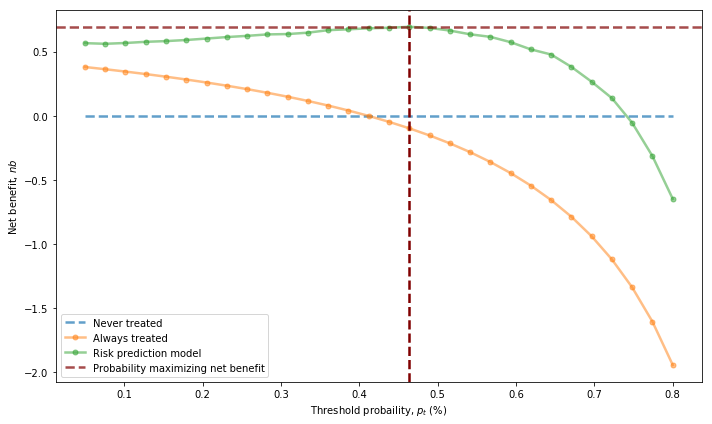

In [28]:
thresholds = np.linspace(0.05, 0.8, 30)
net_benefits = [net_benefit(y_true, pred_probas, p) for p in thresholds]
always_treated = [net_benefit(y_true, 0, p) for p in thresholds]

plt.figure(figsize=(10, 6))
plt.plot([min(thresholds), max(thresholds)], [0, 0], linestyle="--", label="Never treated", 
         alpha=0.7, linewidth=2.5)
plt.plot(thresholds, always_treated, "o-", label="Always treated", markersize=5, 
         alpha=0.5, linewidth=2.5)
plt.plot(thresholds, net_benefits, "o-", label="Risk prediction model", markersize=5, 
         alpha=0.5, linewidth=2.5)
plt.axvline(x=thresholds[np.argmax(net_benefits)], linestyle="--", c="maroon", linewidth=2.5)
plt.axhline(y=np.max(net_benefits), linestyle="--", linewidth=2.5,
            label="Probability maximizing net benefit", c="maroon", alpha=0.7)
plt.ylabel("Net benefit, $nb$")
plt.xlabel(r"Threshold probaility, $p_t$ ($\%$)")
plt.legend()
plt.tight_layout()

For this case, the decision curve shows that the prediction model gives higher benefit across all thresholds comapred to always treating individuals. Due to the imbalanced outcomes where $y_1$ outnumbers $y_0$, always treating individuals does not give a higher number of false positives than true positives meaning that $nb > 0$ for $p_t < 75 \%$. Moreover, using a threshold $p_t > 55 \%$ to issue treatment leads to a decrease in $nb$ from fewer true positives and considering a $p_t$ between $40 - 50 \%$ for $p(y_1)$ given $a_1$ gives the higest $nb$.